In [39]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import datetime
import time
import matplotlib.pyplot as plt
from etf_tools import (
    EstimatorBucket,
    prepare_etf,  ez_plot,
    evaluate_stacking
)
from etf_tools.ml import prepare_named_etf_gen
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle as sk_shuffle
import xgboost as xgb

plt.style.use('ggplot')
plt.ioff()


In [96]:
class XgbBucket(EstimatorBucket):
    def __init__(self, params, num_boost_round=10, **kwargs):
        self.params = params
        self.num_boost_round = num_boost_round
        self.kwargs = kwargs

    def draw(self, x, y):
        x, y = sk_shuffle(x, y)
        dtrain = xgb.DMatrix(x, label=y)
        bst = xgb.train(self.params, dtrain, num_boost_round=self.num_boost_round, **self.kwargs)
        return bst

def uniform_weighting(est, *args, **kwargs):
    return [1] * len(est)


def patched_accuracy_score(threshold=0.5):
    def acc(y_actual, y_pred):
        yp = 1 * (y_pred >= threshold)
        return accuracy_score(y_actual, yp)
    return acc


def progressive_group_split(name_list):
    group_set = dict()
    idx = 0
    for e in name_list:
        if e not in group_set:
            group_set[e] = idx
            idx += 1

    n_group = len(group_set)
    groups = np.zeros((n_group, len(name_list))).astype(int)
    
    for i, e in enumerate(name_list):
        groups[group_set[e], i] = 1
    
    for i in range(n_group):
        pos_idx, = np.where(groups[i] == 1)
        pos_min = min(pos_idx)
        neg_idx, = np.where(groups[i, :pos_min] == 0)
        yield neg_idx, pos_idx
    

In [3]:
src_dir = '../data/raw/groupbycode/trainingset/'
code = '0050'
sample_file = os.path.join(src_dir, f'{code}.csv')
etf = pd.read_csv(sample_file)
display(etf.shape)
display(etf.head(2))
display(etf.tail(2))
display(etf.dtypes)


(1307, 32)

,code,date,name,open,high,low,close,volume,weekday,ema12,...,low_shadow,open_gap,dif,macd,osc,y_1,y_2,y_3,y_4,y_5
0,50,20130102,元大台灣50,54.0,54.65,53.90,54.40,16487,3,54.400000,...,0.1,0.0,0.000000,0.000000,0.000000,54.85,54.50,54.25,53.9,54.1
1,50,20130103,元大台灣50,54.9,55.05,54.65,54.85,29020,4,54.469231,...,0.2,0.5,0.035897,0.007179,0.028718,54.50,54.25,53.90,54.1,54.5


,code,date,name,open,high,low,close,volume,weekday,ema12,...,low_shadow,open_gap,dif,macd,osc,y_1,y_2,y_3,y_4,y_5
1305,50,20180503,元大台灣50,79.05,79.05,78.35,78.55,8823,4,80.015438,...,0.20,-0.35,-0.972590,-0.753400,-0.219191,78.95,NaN,NaN,NaN,NaN
1306,50,20180504,元大台灣50,78.55,79.00,78.40,78.95,3475,5,79.851525,...,0.15,0.00,-0.985539,-0.799827,-0.185711,NaN,NaN,NaN,NaN,NaN


code              int64
date              int64
name             object
open            float64
high            float64
low             float64
close           float64
volume            int64
weekday           int64
ema12           float64
ema26           float64
rsv             float64
k               float64
d               float64
upward          float64
downward        float64
rs              float64
rsi             float64
kbody           float64
kbody_top       float64
kbody_bottom    float64
up_shadow       float64
low_shadow      float64
open_gap        float64
dif             float64
macd            float64
osc             float64
y_1             float64
y_2             float64
y_3             float64
y_4             float64
y_5             float64
dtype: object

In [25]:
cont_feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'ema12', 'ema26', 'rsv', 'k', 'd', 'upward',
    'downward', 'rsi', 'open_gap', 'macd', 'osc', 'kbody'
]
cate_feature_cols = [f'month_{i + 1}' for i in range(12)] + [f'week_{i + 1}' for i in range(5)]

label_cols = ['y_1']


def feature_prep(df):
    months = pd.get_dummies(pd.Series(df.date.apply(lambda e: (e // 100) % 100)), prefix='month')
    weeks = pd.get_dummies(pd.Series(df.date.apply(lambda e: 1 + (e % 100) // 7)), prefix='week')
    return pd.concat([months, weeks, df[cont_feature_cols]], axis=1)


def rnn_feature_trans(df):
    conts = df[cont_feature_cols]
    norms = ((conts - conts.mean()) / conts.std()).fillna(0)
    return pd.concat([df[cate_feature_cols], norms], axis=1)


def xgb_feature_trans(df):
    return pd.Series(rnn_feature_trans(df).values.flatten())


def named_by_date(df_gen):
    for df in df_gen:
        yr_month = df.date.values[0] // 100
        yield f'{yr_month}'

In [26]:
%%time

X_all, y_all, names = prepare_etf(sample_file, cont_feature_cols + cate_feature_cols, label_cols, window=5,
                           etf_prep=lambda df: df.dropna(subset=label_cols),
                           feature_prep=feature_prep,
                           name_prep=named_by_date,
                           label_prep=lambda df: 1 * (df[label_cols].diff().fillna(0) > 0),
                           feature_trans=xgb_feature_trans)


CPU times: user 3.36 s, sys: 4.06 ms, total: 3.36 s
Wall time: 3.36 s


In [27]:
X_all.shape, y_all.shape, len(names)

((1302, 170), (1302, 1, 1), 1302)

In [36]:
X_train, X_test, y_train, y_test, name_train, name_test = train_test_split(X_all, y_all, names, test_size=1, shuffle=False)

In [98]:
g = list(progressive_group_split(names))

{'201301': 0, '201302': 1, '201303': 2, '201304': 3, '201305': 4, '201306': 5, '201307': 6, '201308': 7, '201309': 8, '201310': 9, '201311': 10, '201312': 11, '201401': 12, '201402': 13, '201403': 14, '201404': 15, '201405': 16, '201406': 17, '201407': 18, '201408': 19, '201409': 20, '201410': 21, '201411': 22, '201412': 23, '201501': 24, '201502': 25, '201503': 26, '201504': 27, '201505': 28, '201506': 29, '201507': 30, '201508': 31, '201509': 32, '201510': 33, '201511': 34, '201512': 35, '201601': 36, '201602': 37, '201603': 38, '201604': 39, '201605': 40, '201606': 41, '201607': 42, '201608': 43, '201609': 44, '201610': 45, '201611': 46, '201612': 47, '201701': 48, '201702': 49, '201703': 50, '201704': 51, '201705': 52, '201706': 53, '201707': 54, '201708': 55, '201709': 56, '201710': 57, '201711': 58, '201712': 59, '201801': 60, '201802': 61, '201803': 62, '201804': 63, '201805': 64}


In [99]:
i = 0
for n, p in g:
    print(n.shape, p.shape)
#     print(p)
    if i > 10:
        break

(0,) (18,)
(18,) (13,)
(31,) (21,)
(52,) (20,)
(72,) (22,)
(94,) (19,)
(113,) (23,)
(136,) (21,)
(157,) (20,)
(177,) (22,)
(199,) (21,)
(220,) (22,)
(242,) (18,)
(260,) (17,)
(277,) (21,)
(298,) (21,)
(319,) (21,)
(340,) (20,)
(360,) (22,)
(382,) (21,)
(403,) (21,)
(424,) (22,)
(446,) (20,)
(466,) (24,)
(490,) (20,)
(510,) (13,)
(523,) (22,)
(545,) (20,)
(565,) (20,)
(585,) (21,)
(606,) (22,)
(628,) (21,)
(649,) (20,)
(669,) (21,)
(690,) (21,)
(711,) (23,)
(734,) (21,)
(755,) (13,)
(768,) (23,)
(791,) (19,)
(810,) (21,)
(831,) (21,)
(852,) (20,)
(872,) (23,)
(895,) (19,)
(914,) (20,)
(934,) (22,)
(956,) (22,)
(978,) (16,)
(994,) (18,)
(1012,) (23,)
(1035,) (18,)
(1053,) (20,)
(1073,) (23,)
(1096,) (21,)
(1117,) (23,)
(1140,) (22,)
(1162,) (19,)
(1181,) (22,)
(1203,) (21,)
(1224,) (22,)
(1246,) (13,)
(1259,) (23,)
(1282,) (18,)
(1300,) (2,)


In [64]:
from sklearn.model_selection.


# KFold??


ImportError: cannot import name '_BaseKFold'

# Xgboost training

In [7]:
dtrain = xgb.DMatrix(
    X_all,
    label=y_all,
)

In [8]:
%%time

params={ 
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'seed':0, 

    'max_depth': 5,
    'min_child_weight': 9,
    
    'n_estimators': 10,
    'eta': 0.01,  # eta
    'subsample': 0.5,
    'colsample_bytree': 0.5, 
    'nthread': 16,
}

cv_out = xgb.cv(params=params,
                dtrain=dtrain, 
                num_boost_round=5000,
                nfold=5,
                metrics=['error'],
                early_stopping_rounds=1000)

CPU times: user 2min 10s, sys: 3.35 s, total: 2min 13s
Wall time: 9.1 s


In [9]:
cv_out.tail()

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.488444,0.026734,0.415896,0.010549


In [10]:
params={ 
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'seed':0, 

    'max_depth': 5,
    'min_child_weight': 9,
    
    'n_estimators': 10,
    'eta': 0.01,  # eta
    'subsample': 0.5,
    'colsample_bytree': 0.5, 
    'nthread': 16,
}

xgb_bucket = XgbBucket(params, num_boost_round=1000, early_stopping_rounds=None)

In [11]:
(X_train, y_train), (X_val, y_val) = (X_all[:-10], y_all[:-10]), (X_all[-10:], y_all[-10:])

In [ ]:
%%time
tic = time.time()

z = [evaluate_stacking(xgb_bucket, uniform_weighting, x_val=xgb.DMatrix(X_val), y_val=np.vstack(y_val),
                       bucket_kwargs=dict(x=X_train, y=y_train),
                       metrics=[patched_accuracy_score(threshold=0.5)], n_stack=50) for _ in range(10)]

toc = time.time()

In [13]:
print(f'{toc - tic:.3f}')

820.349


In [17]:
zz = pd.concat(z, axis=0)
zz.columns = [f'{i + 1}' for i in range(50)]
display(zz)

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
accuracy_score,0.5,0.50,0.533333,0.575,0.56,0.550000,0.557143,0.5500,0.544444,0.55,...,0.539024,0.540476,0.539535,0.543182,0.540000,0.539130,0.540426,0.543750,0.544898,0.544
accuracy_score,0.6,0.55,0.566667,0.600,0.60,0.583333,0.571429,0.5500,0.544444,0.55,...,0.563415,0.564286,0.567442,0.568182,0.568889,0.569565,0.568085,0.568750,0.567347,0.570
accuracy_score,0.6,0.60,0.600000,0.625,0.58,0.583333,0.571429,0.5750,0.566667,0.56,...,0.534146,0.535714,0.534884,0.534091,0.537778,0.539130,0.542553,0.541667,0.542857,0.544
accuracy_score,0.6,0.60,0.600000,0.625,0.60,0.566667,0.585714,0.5750,0.566667,0.58,...,0.570732,0.569048,0.569767,0.568182,0.566667,0.565217,0.565957,0.562500,0.559184,0.564
accuracy_score,0.7,0.65,0.666667,0.625,0.60,0.583333,0.600000,0.6250,0.611111,0.61,...,0.553659,0.550000,0.551163,0.554545,0.553333,0.554348,0.553191,0.554167,0.553061,0.552
accuracy_score,0.6,0.55,0.566667,0.575,0.56,0.550000,0.557143,0.5625,0.555556,0.56,...,0.560976,0.561905,0.565116,0.563636,0.564444,0.565217,0.565957,0.562500,0.565306,0.564
accuracy_score,0.4,0.60,0.600000,0.550,0.56,0.583333,0.614286,0.6125,0.588889,0.59,...,0.553659,0.554762,0.555814,0.556818,0.560000,0.560870,0.565957,0.564583,0.563265,0.564
accuracy_score,0.4,0.45,0.500000,0.500,0.50,0.500000,0.514286,0.5125,0.522222,0.54,...,0.541463,0.540476,0.541860,0.543182,0.546667,0.543478,0.542553,0.545833,0.546939,0.544
accuracy_score,0.6,0.60,0.633333,0.600,0.56,0.550000,0.528571,0.5375,0.544444,0.53,...,0.560976,0.559524,0.555814,0.556818,0.555556,0.556522,0.555319,0.558333,0.555102,0.556
accuracy_score,0.4,0.50,0.533333,0.525,0.56,0.550000,0.542857,0.5500,0.566667,0.55,...,0.543902,0.545238,0.548837,0.552273,0.553333,0.552174,0.555319,0.556250,0.557143,0.556


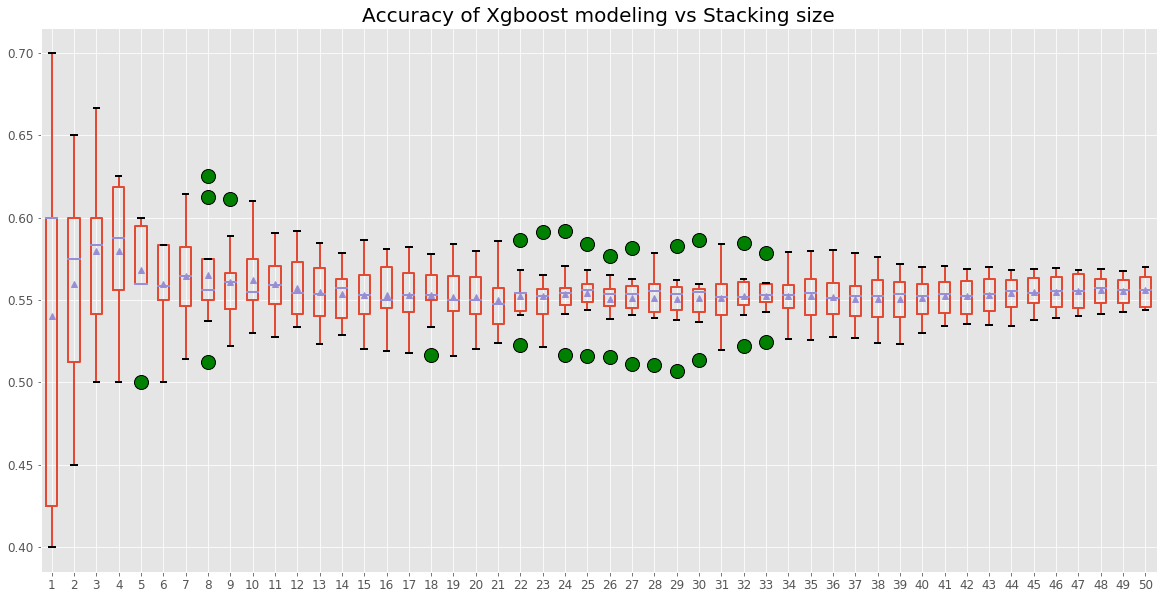

In [21]:
fig = ez_plot(zz, fontsize=12, kind='box', showmeans=True, 
        title_prop={'label': 'Accuracy of Xgboost modeling vs Stacking size', 'size': 20},
        boxprops={'linewidth': 2, 'markerfacecolor': 'green'},
        whiskerprops={'linewidth': 2}, capprops={'linewidth': 2},
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        flierprops=dict(marker='o', markerfacecolor='green', markersize=14, linestyle='none'))

display(fig)

In [22]:
fig.savefig('static/xgboost_stacking.jpg')